# MOLE CLASSIFIER

## Overview

Moles are a common type of skin growth. They often appear as small areas and are caused by clusters of dark brown pigment-forming cells. Most people have between 10 and 40 moles that appear during early childhood or adolescence and may change in appearance or fade over time. Most moles are harmless. However, occasionally they become cancerous. Being aware of changes on your skin is important to detecting cancerous moles.

The objective of the project is building a neural network that can disginguish benign and malignant moles. The dataset is taken from a "SIIM-ISIC Melanoma Classification Challenge" hosted on Kaggle during the Summer of 2020 (https://challenge2020.isic-archive.com/). 

There are 1800 images of benign moles and 1497 pictures of malignant labeled moles available for training and 660 for testing. All images were resized to low resolution (224x224x3) RGB.

## Workflow
<b><br>Step 1: Import libraries.</br><b>
<b><br>Step 2: Load and preprocess train and test datasets.</br><b>
<b><br>Step 3: Plot sample of images.</br><b>
<b><br>Step 4: Build CNN model.</br><b>
<b><br>Step 5: Compile and train the model.</br><b>
<b><br>Step 6: Plot training and test accuracy.</br><b>
<b><br>Step 7: Analyse the predictions.</br><b>
<b><br>Step 8: Plot correctly predicted images (sample).</br><b>
<b><br>Step 9: Plot incorrectly predicted images (sample).</br><b>  

### Step 1: Import libraries.

In [252]:
# to clean the enviorenment
%reset
# for folder manipulation
import os
# for plotting
import matplotlib.pyplot as plt
# for array manipulation
import numpy as np
# for one hot encoding
from keras.utils.np_utils import to_categorical
# for building NN
from keras import models, layers, optimizers
# for prediction resutls
from sklearn.metrics import accuracy_score
# for image loading
from tensorflow.keras.preprocessing import image

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Step 2: Load train and test datasets.

In [253]:
# check the structure of the train (test) folders
my_folder = './skin_cancer/data/train'
print(os.listdir(my_folder)) 

['malignant', 'benign']


In [254]:
# save paths to benign and malignant folders for the loading loop
benign = './skin_cancer/data/train/benign'
malignant = './skin_cancer/data/train/malignant'

# containers for loading images
x_train_imgs = []
y_train_imgs = []

# loop over 2 folders and load images
i = 0
for name_dir in [benign, malignant]: 
    for picture in next(os.walk(name_dir))[2]:
        x = image.load_img(str(name_dir) + '/' + picture, target_size = (224,224))
        x = image.img_to_array(x)
        x = x.astype('float32')
        x /= 255
        x_train_imgs.append(x)
        y_train_imgs.append(int(i))
    i = i + 1

# convert images to an array
x_train = np.array(x_train_imgs)
# one hot encoding for train labels
y_train = to_categorical(y_train_imgs, 2)

# check the shapes of results
print("x_train array shape: " + str(x_train.shape))
print("y_train array shape: " + str(y_train.shape))

x_train array shape: (2637, 224, 224, 3)
y_train array shape: (2637, 2)


We just loaded all images that will be used for training our model into a training dataset and converted it into a 4-dimensional array. Based on array shape, we see 2637 images available. Each picture has an RGB structure (3 colours) and 224:224 pixels.
Also, note that the y_train array is one hot encoded representation of the labels (malignant vs benign) of the train images.

In [255]:
# save paths to benign and malignant folders for the loading loop
benign = './skin_cancer/data/test/benign'
malignant = './skin_cancer/data/test/malignant'

# containers for loading images
x_test_imgs = []
y_test_imgs = []

# loop over 2 folders and load images
i = 0
for name_dir in [benign, malignant]: 
    for picture in next(os.walk(name_dir))[2]:
        x_test = image.load_img(str(name_dir) + '/' + picture, target_size = (224,224))
        x_test = image.img_to_array(x_test)
        x_test = x_test.astype('float32')
        x_test /= 255
        x_test_imgs.append(x_test)
        y_test_imgs.append(int(i))
    i = i + 1

# convert images to an array
x_test = np.array(x_test_imgs)
# one hot encoding for train labels
y_test = to_categorical(y_test_imgs, 2)

# check the shapes of results
print("x_test array shape: " + str(x_test.shape))
print("y_test array shape: " + str(y_test.shape))

x_test array shape: (660, 224, 224, 3)
y_test array shape: (660, 2)


The same steps we did on train data were applied to a folder with test images. Based on the arrays' shapes, we see 660 pictures available for us to test the model.

### Step 3: Plot sample of images.

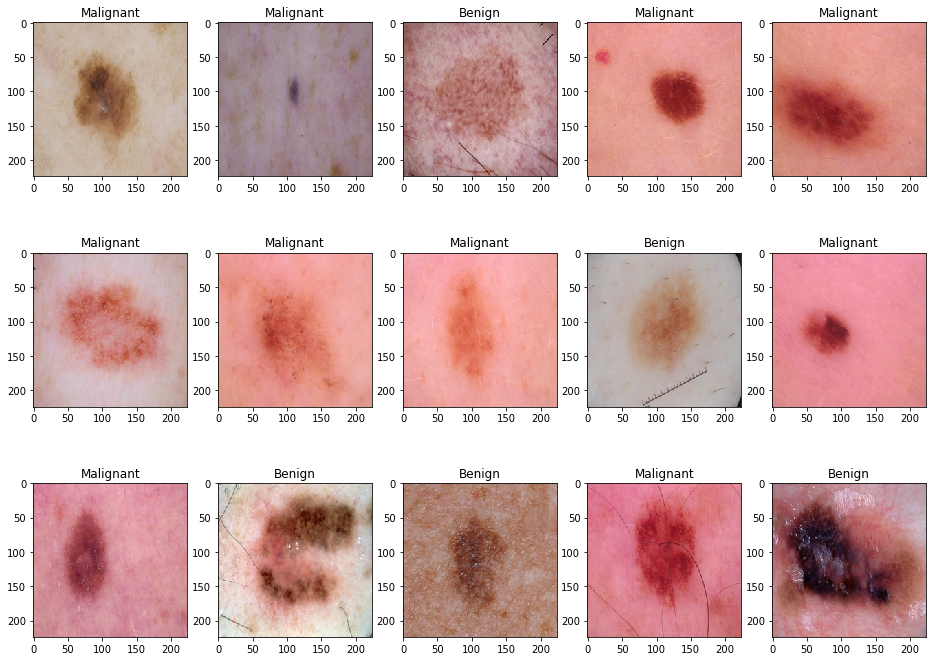

In [256]:
# generate 15 random integers from a indicies of train data
rand_images = list(np.random.randint(low = 1, high = len(x_train), size = 15))

# plot first 15 images of moles indicating their labels
fig = plt.figure(figsize=(16, 12))
columns = 5
rows = 3

# run through train dataset and plot images based on randomely generated number
for i in range(1, len(rand_images) + 1):
    my_plot = fig.add_subplot(rows, columns, i)
    if y_train[rand_images[i-1]][0] == 0:
        my_plot.title.set_text('Benign')
    else:
        my_plot.title.set_text('Malignant')
    plt.imshow(x_train[rand_images[i-1]], interpolation = 'nearest')
plt.show()

As expected, our randomly generated pictures include both benign and malignant moles. A quick look at the pictures proves that correctly classifying skin lesions is challenging. Even based on a small sample, we observe both types of moles to have various colours, colour depths and shapes.

### Step 4: Build CNN model.

I built a 4-layered convolutional network with 2 Conv2D and 2 Dense layers. Also, the model includes 2 Dropout layers to prevent overfitting train data. The activation function is "relu" for each layer except the last one, where "sigmoid" is used for a binary classification task. The padding argument "same" was applied, and "glorot_uniform" kernel initialiser was used. However, these 2 hyperparameters didn't affect validation accuracy much during the experimentation phase. As a result, the model built has 25.7 million parameters.

In [257]:
model = models.Sequential()
model.add(layers.Conv2D(64, 
                        kernel_size = (3, 3),
                        padding = 'Same',
                        input_shape = x_train[0].shape,
                        activation = 'relu', 
                        kernel_initializer ='glorot_uniform'
                       ))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.20))
model.add(layers.Conv2D(64, 
                        kernel_size = (3, 3),
                        padding = 'Same', 
                        activation = 'relu', 
                        kernel_initializer = 'glorot_uniform'
                       ))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.20))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(2, activation = 'sigmoid'))

# check the model architecture
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 112, 112, 64)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 56, 56, 64)      

### Step 5: Compile and train the model.

In [258]:
# compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# train the model
history = model.fit(x_train,
                    y_train, 
                    batch_size = 128,
                    epochs = 30,
                    validation_split = 0.2,
                    shuffle = True,
                    verbose = 1
                   )

Epoch 1/30
17/17 [==============================] - 82s 5s/step - loss: 3.2415 - accuracy: 0.4993 - val_loss: 0.6959 - val_accuracy: 0.0000e+00
Epoch 2/30
17/17 [==============================] - 74s 4s/step - loss: 0.6778 - accuracy: 0.6828 - val_loss: 0.9173 - val_accuracy: 0.0000e+00
Epoch 3/30
17/17 [==============================] - 74s 4s/step - loss: 0.6030 - accuracy: 0.6828 - val_loss: 1.2808 - val_accuracy: 0.0000e+00
Epoch 4/30
17/17 [==============================] - 73s 4s/step - loss: 0.5098 - accuracy: 0.6894 - val_loss: 1.9660 - val_accuracy: 0.0398
Epoch 5/30
17/17 [==============================] - 73s 4s/step - loss: 0.4728 - accuracy: 0.7330 - val_loss: 1.9940 - val_accuracy: 0.0795
Epoch 6/30
17/17 [==============================] - 73s 4s/step - loss: 0.4339 - accuracy: 0.7544 - val_loss: 2.8885 - val_accuracy: 0.0265
Epoch 7/30
17/17 [==============================] - 73s 4s/step - loss: 0.4436 - accuracy: 0.7606 - val_loss: 1.3261 - val_accuracy: 0.2197
Epoch 8/

### Step 6: Plot trainig and test accuracy.

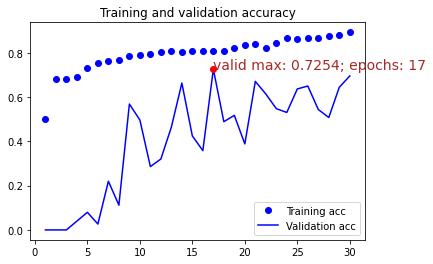

In [259]:
# containers for plotting
list_max_acc = []
list_max_val = []
list_epochs = []
list_optim = []

# collect accuracy results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# prepare a sequence of epochs for plotting
epochs = range(1, len(acc) + 1)

# collect the best model
list_max_acc.append(acc[val_acc.index(max(val_acc))])
list_max_val.append(max(val_acc))
list_epochs.append(epochs[val_acc.index(max(val_acc))])
list_optim.append('adam')

# plot train/validaton result
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Add dot and corresponding text
plt.plot(epochs[val_acc.index(max(val_acc))], max(val_acc), 'ro')
plt.text(epochs[val_acc.index(max(val_acc))], max(val_acc),
         'valid max: ' + str(round(max(val_acc), 4)) + '; epochs: ' + str(epochs[val_acc.index(max(val_acc))]),
        fontsize = 14, color = "brown",)

plt.show()

As we can see on the plot, training accuracy reached ~80% near the 10th epoch and slowly improved with extra training steps. Validation accuracy reached its peak 17th epoch and continued at this level with some variations till the end of the model training.

### Step 7: Analyse the predictions.

In [260]:
# predict labels for the test dataset
y_pred = model.predict(x_test)

21/21 [==============================] - 7s 289ms/step


In [261]:
# check how many correct and incorrect predictios are made
correct_pred = 0
wrong_pred = 0

# count correct and incorrect predictions
for i in range(len(y_test)):
    if y_pred[i][0] > y_pred[i][1] and y_test[i][0] == 1:
        correct_pred +=1
    elif y_pred[i][0] < y_pred[i][1] and y_test[i][0] == 0:
        correct_pred +=1
    else:
        wrong_pred +=1

# print the result        
print("Correctly predicted: "+ str(correct_pred) +"("+ str(round(correct_pred/len(y_pred)*100, ndigits = 2)) +"%)"+
      ". Incorrectly predicted: "+ str(wrong_pred) +"("+ str(round(wrong_pred/len(y_pred)*100, ndigits = 2)) +"%)"+
      ". Total images: " + str(len(y_pred)))

Correctly predicted: 533(80.76%). Incorrectly predicted: 127(19.24%). Total images: 660


The trained CNN model achieved 80.76% prediction accuracy on a never seen test set of images. Out of 660 images available, 533 were correctly classified as benign or malignant, while 127 (19.24%) pictures were allocated to the wrong group. Overall, exceeding the 80% mark is an impressive result, considering the complexity of model architecture was limited by the computing power of the local machine.

### Step 8: Plot correctly predicted images (sample).

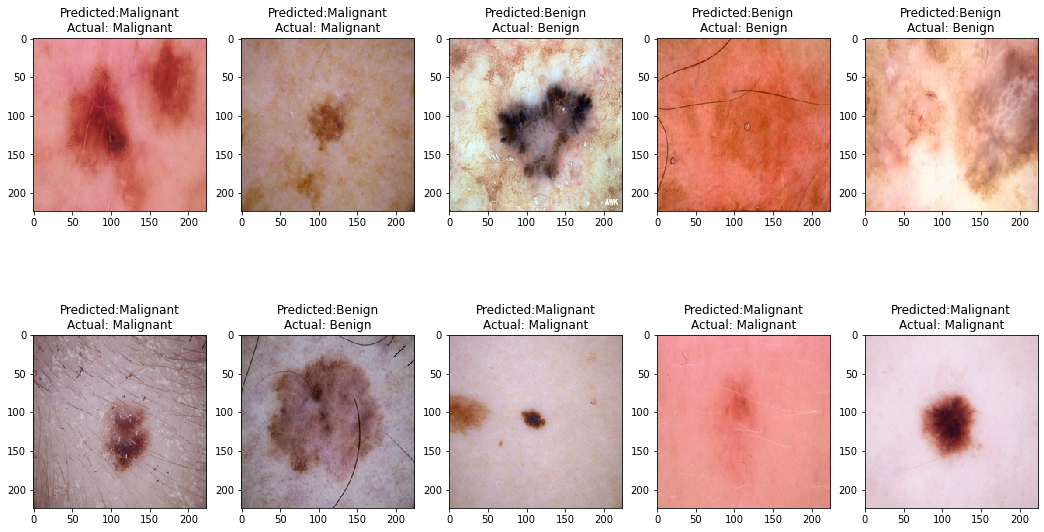

In [262]:
# containers to count correct and incorrect projections
prop_class = []
mis_class = []

# loop through test and predictons, compare labels and count result
i = 0
for i in range(len(y_test)):
    if(np.argmax(y_test[i]) == np.argmax(y_pred[i])):
        prop_class.append(i)
    else:
        mis_class.append(i)

    
# define plot architecture
w = 60
h = 40
fig=plt.figure(figsize=(18, 10))
columns = 5
rows = 2

# function for labeling
def my_label(name_code):
    if name_code == 0:
        return "Malignant"
    else:
        return "Benign"
    
# define indicies for 10 random correctly predicted pictures  
rand_images = list(np.random.randint(low = 1, high = len(prop_class), size = 10))

# plot 10 images
for i in range(len(rand_images)):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title("Predicted:" + my_label(np.argmax(y_pred[prop_class[rand_images[i]]])) + "\n" +
    "Actual: " + my_label(np.argmax(y_test[prop_class[rand_images[i]]])))
    plt.imshow(x_test_imgs[prop_class[rand_images[i]]], interpolation = 'nearest')
plt.show()


### Step 9: Plot incorrectly predicted images (sample).

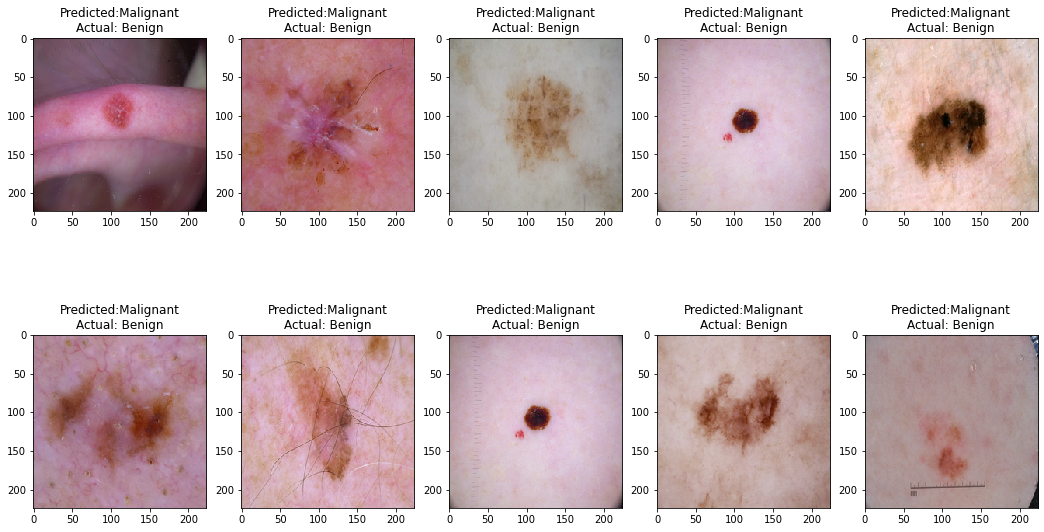

In [264]:
# define plot architecture
w = 60
h = 40
fig=plt.figure(figsize = (18, 10))
columns = 5
rows = 2

# define indicies for 10 random incorrectly predicted pictures  
rand_images = list(np.random.randint(low = 1, high = len(mis_class), size = 10))

# plot 10 images
for i in range(len(rand_images)):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title("Predicted:" + my_label(np.argmax(y_pred[mis_class[rand_images[i]]])) + "\n" +
    "Actual: " + my_label(np.argmax(y_test[mis_class[rand_images[i]]])))
    plt.imshow(x_test_imgs[mis_class[rand_images[i]]], interpolation = 'nearest')

plt.show()

## Summary
The project successfully achieved the objective of building a convolutional neural network that can classify cancerous and non-cancerous moles. CNN trained on 2637 images and achieved 80.76% prediction accuracy on the test dataset. For the task, a 4-layered neural network with dropout layers was pretrained, which includes 25.7 million parameters. The project was done on a MacBook Pro 2.6 GHz 6-Core Intel Core i7 processor and 16GB of RAM. Hitting an 80% accuracy mark is a respectful result, which, however, could be improved by adding more layers or using pretrained CNN. More computing power has to be acquired to run experiments on more complex models.